In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from utils import color_df
from mlxtend.frequent_patterns import apriori
from scipy import stats
import statsmodels.api as sm

In [3]:
# Dowlaad the data from github repo 
df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/candy-data.csv')
df.sample(10)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
20,Haribo Sour Bears,0,1,0,0,0,0,0,0,1,0.465,0.465,51.412430
10,Charleston Chew,1,0,0,0,1,0,0,1,0,0.604,0.511,38.975037
14,Dum Dums,0,1,0,0,0,0,1,0,0,0.732,0.034,39.460556
45,Now & Later,0,1,0,0,0,0,0,0,1,0.220,0.325,39.446800
84,Whoppers,1,0,0,0,0,1,0,0,1,0.872,0.848,49.524113
23,HersheyÕs Krackel,1,0,0,0,0,1,0,1,0,0.430,0.918,62.284481
11,Chewey Lemonhead Fruit Mix,0,1,0,0,0,0,0,0,1,0.732,0.511,36.017628
33,M&MÕs,1,0,0,0,0,0,0,0,1,0.825,0.651,66.574585
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
24,HersheyÕs Milk Chocolate,1,0,0,0,0,0,0,1,0,0.430,0.918,56.490501


### The data contains the following fields:

For binary variables, 1 means yes, 0 means no.


Header | Description
-------|------------
chocolate | Does it contain chocolate?
fruity | Is it fruit flavored?
caramel | Is there caramel in the candy?
peanutalmondy | Does it contain peanuts, peanut butter or almonds?
nougat | Does it contain nougat?
crispedricewafer | Does it contain crisped rice, wafers, or a cookie component?
hard | Is it a hard candy?
bar | Is it a candy bar?
pluribus | Is it one of many candies in a bag or box?
sugarpercent | The percentile of sugar it falls under within the data set.
pricepercent | The unit price percentile compared to the rest of the set.
winpercent | The overall win percentage according to 269,000 matchups.


In [4]:
# Getting a glimpse of the dataset as well as checking for missing values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   competitorname    85 non-null     object 
 1   chocolate         85 non-null     int64  
 2   fruity            85 non-null     int64  
 3   caramel           85 non-null     int64  
 4   peanutyalmondy    85 non-null     int64  
 5   nougat            85 non-null     int64  
 6   crispedricewafer  85 non-null     int64  
 7   hard              85 non-null     int64  
 8   bar               85 non-null     int64  
 9   pluribus          85 non-null     int64  
 10  sugarpercent      85 non-null     float64
 11  pricepercent      85 non-null     float64
 12  winpercent        85 non-null     float64
dtypes: float64(3), int64(9), object(1)
memory usage: 8.8+ KB


In [5]:
# Overview about the descriptive stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
chocolate,85.0,0.435294,0.498738,0.000000,0.000000,0.000000,1.000000,1.00000
fruity,85.0,0.447059,0.500140,0.000000,0.000000,0.000000,1.000000,1.00000
caramel,85.0,0.164706,0.373116,0.000000,0.000000,0.000000,0.000000,1.00000
peanutyalmondy,85.0,0.164706,0.373116,0.000000,0.000000,0.000000,0.000000,1.00000
nougat,85.0,0.082353,0.276533,0.000000,0.000000,0.000000,0.000000,1.00000
crispedricewafer,85.0,0.082353,0.276533,0.000000,0.000000,0.000000,0.000000,1.00000
hard,85.0,0.176471,0.383482,0.000000,0.000000,0.000000,0.000000,1.00000
bar,85.0,0.247059,0.433861,0.000000,0.000000,0.000000,0.000000,1.00000
pluribus,85.0,0.517647,0.502654,0.000000,0.000000,1.000000,1.000000,1.00000
sugarpercent,85.0,0.478647,0.282778,0.011000,0.220000,0.465000,0.732000,0.98800


## Feature Engineering

In [6]:
# Div Winpercent by 100 to have it in the same scale as the other two percentage variables 
df['winpercent'] = round(df['winpercent']/100, 3)
table = df.head(10) 
table.set_index("competitorname").style.applymap(color_df)

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
competitorname,,,,,,,,,,,,
100 Grand,1,0,1,0,0,1,0,1,0,0.732000,0.860000,0.670000
3 Musketeers,1,0,0,0,1,0,0,1,0,0.604000,0.511000,0.676000
One dime,0,0,0,0,0,0,0,0,0,0.011000,0.116000,0.323000
One quarter,0,0,0,0,0,0,0,0,0,0.011000,0.511000,0.461000
Air Heads,0,1,0,0,0,0,0,0,0,0.906000,0.511000,0.523000
Almond Joy,1,0,0,1,0,0,0,1,0,0.465000,0.767000,0.503000
Baby Ruth,1,0,1,1,1,0,0,1,0,0.604000,0.767000,0.569000
Boston Baked Beans,0,0,0,1,0,0,0,0,1,0.313000,0.511000,0.234000
Candy Corn,0,0,0,0,0,0,0,0,1,0.906000,0.325000,0.380000


In [7]:
# Combine the two variables
# Higher value -> the candy is sweet as well as cheap.
df['sugarbyprice'] = round(df['sugarpercent'].div(df['pricepercent']), 3) 

# Higher value -> the candy is more liked as well as cheap.
df['winbyprice'] = round(df['winpercent'].div(df['pricepercent']), 3) 

# Check the transformations 
df.sample(5)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,sugarbyprice,winbyprice
49,Pop Rocks,0,1,0,0,0,0,1,0,1,0.604,0.837,0.413,0.722,0.493
25,HersheyÕs Special Dark,1,0,0,0,0,0,0,1,0,0.430,0.918,0.592,0.468,0.645
56,Rolo,1,0,1,0,0,0,0,0,1,0.860,0.860,0.657,1.000,0.764
28,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,0.768,0.613,1.503
31,Lifesavers big ring gummies,0,1,0,0,0,0,0,0,0,0.267,0.279,0.529,0.957,1.896


# EDA

All the most fav candies contain choccolate, none of them are either fruity or hard. Perhaps, penaut or almond helps in be liked by people. Also, interesting to see there are not one of many candies in the box. 

In [8]:
# Most fav candies 
df.sort_values('winpercent', ascending=False).head(10)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,sugarbyprice,winbyprice
52,ReeseÕs Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.720,0.651,0.842,1.106,1.293
51,ReeseÕs Miniatures,1,0,0,1,0,0,0,0,0,0.034,0.279,0.819,0.122,2.935
79,Twix,1,0,1,0,0,1,0,1,0,0.546,0.906,0.816,0.603,0.901
28,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,0.768,0.613,1.503
64,Snickers,1,0,1,1,1,0,0,1,0,0.546,0.651,0.767,0.839,1.178
53,ReeseÕs pieces,1,0,0,1,0,0,0,0,1,0.406,0.651,0.734,0.624,1.127
36,Milky Way,1,0,1,0,1,0,0,1,0,0.604,0.651,0.731,0.928,1.123
54,ReeseÕs stuffed with pieces,1,0,0,1,0,0,0,0,0,0.988,0.651,0.729,1.518,1.120
32,Peanut butter M&MÕs,1,0,0,1,0,0,0,0,1,0.825,0.651,0.715,1.267,1.098
42,Nestle Butterfinger,1,0,0,1,0,0,0,1,0,0.604,0.767,0.707,0.787,0.922


In [9]:
# Least fav candies 
df.sort_values('winpercent', ascending=False).tail(10)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,sugarbyprice,winbyprice
19,Haribo Happy Cola,0,0,0,0,0,0,0,0,1,0.465,0.465,0.342,1.000,0.735
70,Sugar Babies,0,0,1,0,0,0,0,0,1,0.965,0.767,0.334,1.258,0.435
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,0.323,0.095,2.784
71,Sugar Daddy,0,0,1,0,0,0,0,0,0,0.418,0.325,0.322,1.286,0.991
57,Root Beer Barrels,0,0,0,0,0,0,1,0,1,0.732,0.069,0.297,10.609,4.304
26,Jawbusters,0,1,0,0,0,0,1,0,1,0.093,0.511,0.281,0.182,0.550
72,Super Bubble,0,1,0,0,0,0,0,0,0,0.162,0.116,0.273,1.397,2.353
12,Chiclets,0,1,0,0,0,0,0,0,1,0.046,0.325,0.245,0.142,0.754
7,Boston Baked Beans,0,0,0,1,0,0,0,0,1,0.313,0.511,0.234,0.613,0.458
44,Nik L Nip,0,1,0,0,0,0,0,0,1,0.197,0.976,0.224,0.202,0.230


If we sort by price the game changes a lot, here the most fav candies can be either chocco or fruity. Probably, plays a good part the fact that you get many of them in one box for cheap, compared to the other case.  

In [10]:
df.sort_values('winbyprice', ascending=False).head(10)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,sugarbyprice,winbyprice
76,Tootsie Roll Midgies,1,0,0,0,0,0,0,0,1,0.174,0.011,0.457,15.818,41.545
48,Pixie Sticks,0,0,0,0,0,0,0,0,1,0.093,0.023,0.377,4.043,16.391
15,Fruit Chews,0,1,0,0,0,0,0,0,1,0.127,0.034,0.431,3.735,12.676
14,Dum Dums,0,1,0,0,0,0,1,0,0,0.732,0.034,0.395,21.529,11.618
69,Strawberry bon bons,0,1,0,0,0,0,1,0,1,0.569,0.058,0.346,9.810,5.966
22,HersheyÕs Kisses,1,0,0,0,0,0,0,0,1,0.127,0.093,0.554,1.366,5.957
66,Sour Patch Kids,0,1,0,0,0,0,0,0,1,0.069,0.116,0.599,0.595,5.164
67,Sour Patch Tricksters,0,1,0,0,0,0,0,0,1,0.069,0.116,0.528,0.595,4.552
57,Root Beer Barrels,0,0,0,0,0,0,1,0,1,0.732,0.069,0.297,10.609,4.304
59,Sixlets,1,0,0,0,0,0,0,0,1,0.220,0.081,0.347,2.716,4.284


Analyzing the candy components and some possible combinations

In [11]:
print(f"N of choco and fruity {len(df[(df['chocolate']==1)&(df['fruity']==1)])}")
print(f"N of choco and peanutyalmondy {len(df[(df['chocolate']==1)&(df['peanutyalmondy']==1)])}")
print(f"N of choco and pluribus {len(df[(df['chocolate']==1)&(df['pluribus']==1)])}")
print(f"N of choco candies {len(df[df['chocolate']==1])}")
print(f"N of fruity {len(df[df['fruity']==1])}")

N of choco and fruity 1
N of choco and peanutyalmondy 12
N of choco and pluribus 12
N of choco candies 37
N of fruity 38


In [12]:
# This is a good combo but also quite expansive
df[(df['chocolate']==1)&(df['pluribus']==1)].sort_values('winpercent', ascending=False)[:5]

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,sugarbyprice,winbyprice
53,ReeseÕs pieces,1,0,0,1,0,0,0,0,1,0.406,0.651,0.734,0.624,1.127
32,Peanut butter M&MÕs,1,0,0,1,0,0,0,0,1,0.825,0.651,0.715,1.267,1.098
47,Peanut M&Ms,1,0,0,1,0,0,0,0,1,0.593,0.651,0.695,0.911,1.068
33,M&MÕs,1,0,0,0,0,0,0,0,1,0.825,0.651,0.666,1.267,1.023
56,Rolo,1,0,1,0,0,0,0,0,1,0.860,0.860,0.657,1.000,0.764


In [13]:
# Which is the one with both choco and fruit? 
df[(df['chocolate']==1)&(df['fruity']==1)]

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,sugarbyprice,winbyprice
74,Tootsie Pop,1,1,0,0,0,0,1,0,0,0.604,0.325,0.49,1.858,1.508


Check perc yes/no for categorical values

In [14]:
for cat_val in df[df.columns[1:-5]]: 
    print(cat_val)
    print(df[cat_val].value_counts(normalize = True)*100)
    print()

chocolate
0    56.470588
1    43.529412
Name: chocolate, dtype: float64

fruity
0    55.294118
1    44.705882
Name: fruity, dtype: float64

caramel
0    83.529412
1    16.470588
Name: caramel, dtype: float64

peanutyalmondy
0    83.529412
1    16.470588
Name: peanutyalmondy, dtype: float64

nougat
0    91.764706
1     8.235294
Name: nougat, dtype: float64

crispedricewafer
0    91.764706
1     8.235294
Name: crispedricewafer, dtype: float64

hard
0    82.352941
1    17.647059
Name: hard, dtype: float64

bar
0    75.294118
1    24.705882
Name: bar, dtype: float64

pluribus
1    51.764706
0    48.235294
Name: pluribus, dtype: float64



### Pearson Corr

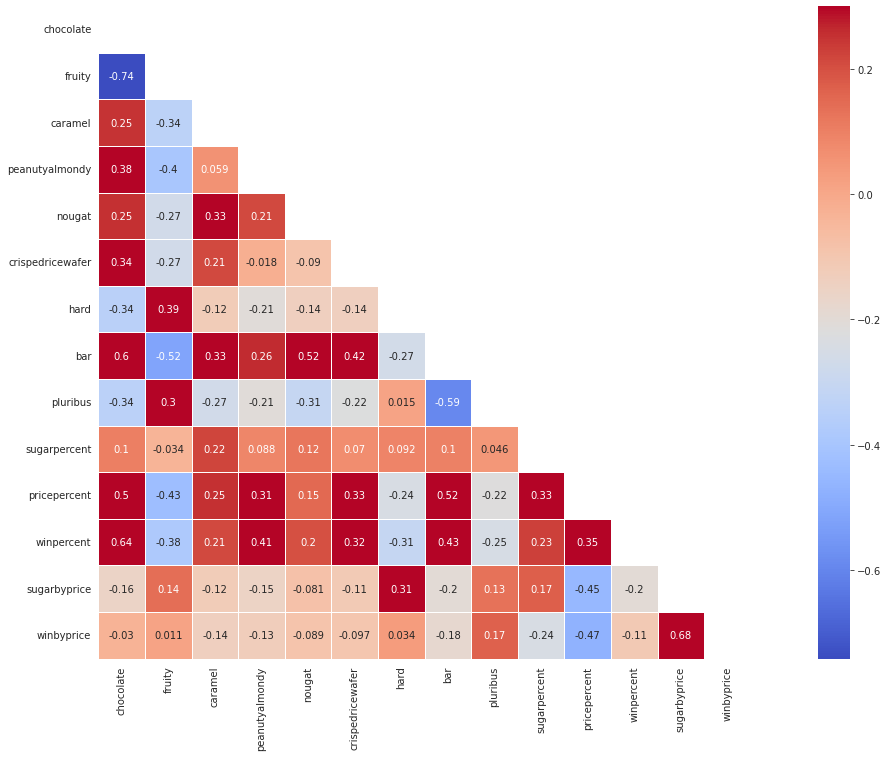

In [15]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(24, 12))
    ax = sns.heatmap(df.corr(), mask=mask, vmax=.3, square=True, annot=True, cmap = 'coolwarm', linewidths=.5)

### Spearman Corr

In [16]:
print("winpercent vs sugar percent {}".format(stats.spearmanr(df.winpercent, df.sugarpercent)))
print("winpercent vs price percent {}".format(stats.spearmanr(df.winpercent, df.pricepercent)))

winpercent vs sugar percent SpearmanrResult(correlation=0.21917627188619349, pvalue=0.04386672037824133)
winpercent vs price percent SpearmanrResult(correlation=0.3546312501902001, pvalue=0.0008682735199554266)


### Apriori Algo

<AxesSubplot:title={'center':'Most Frequent Combination by Top Candies'}, ylabel='itemsets'>

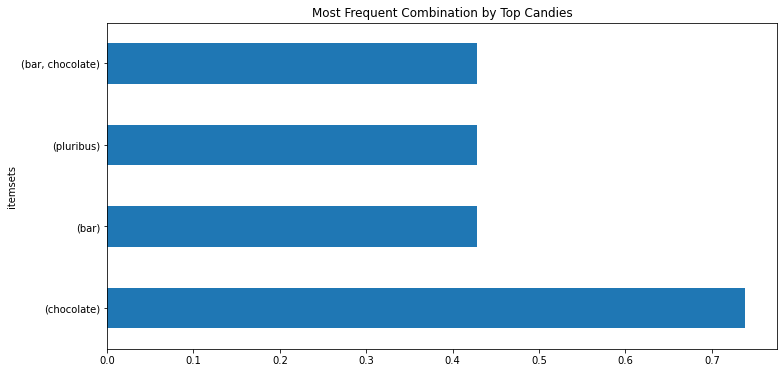

In [17]:
# filter candies greater than 
bests = df[df['winpercent']>df['winpercent'].quantile(.5)]
df_bests =  bests[df.columns[1:-5]]

# use apriori alg with min support .4
result = apriori(df_bests, min_support=0.4,use_colnames=True).sort_values(by='support', ascending=False)

# plot as a bar chart
result.plot(kind='barh',x='itemsets',y='support',title=f'Most Frequent Combination by Top Candies',
                 sort_columns=True,figsize = (12,6),legend=False)

<AxesSubplot:xlabel='fruity', ylabel='winpercent'>

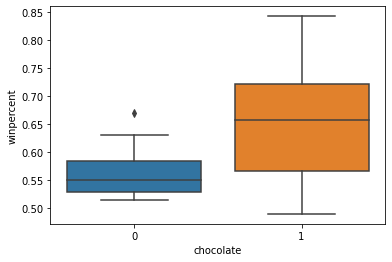

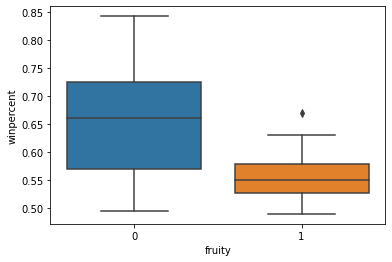

In [18]:
plt.subplot2grid
plt.figure(figsize=(6, 4))
sns.boxplot(x="chocolate", y="winpercent", data=bests)
plt.figure(figsize=(6, 4))
sns.boxplot(x="fruity", y="winpercent", data=bests)

In [19]:
df.columns

Index(['competitorname', 'chocolate', 'fruity', 'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
       'pricepercent', 'winpercent', 'sugarbyprice', 'winbyprice'],
      dtype='object')

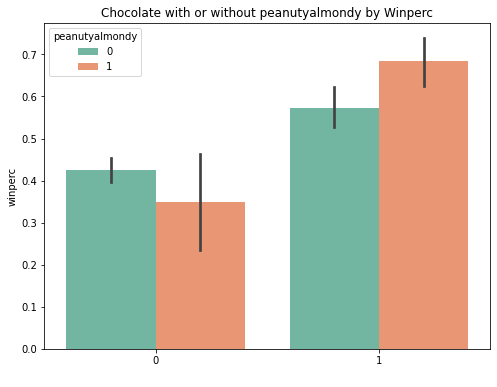

In [20]:
#set a empty canva where to put the bargrahp 
fig, ax = plt.subplots()

#create the bargraphs by player's race
sns.barplot(data = df, 
            x = "chocolate", 
            y = "winpercent", 
            hue = "peanutyalmondy",  palette="Set2")

#Set title and labels for the axis 
plt.title("Chocolate with or without peanutyalmondy by Winperc")
plt.xlabel(" ")
plt.ylabel("winperc")

#set the graph's size
fig.set_size_inches(8, 6)

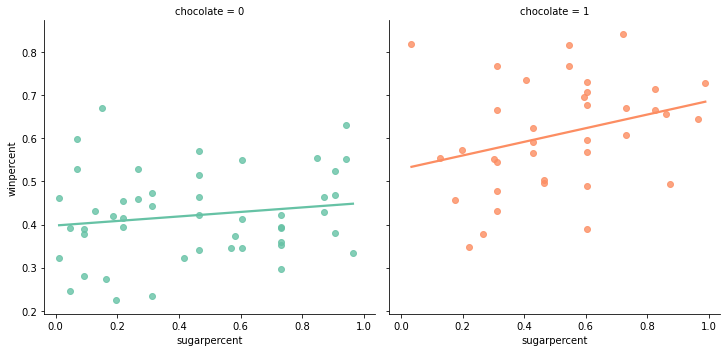

In [21]:
#Scatter plot with a regression line 
sns.lmplot(x = "sugarpercent", y = "winpercent", data = df, 
           hue= "chocolate", col = "chocolate", col_wrap=3, 
           palette="Set2", ci = None)

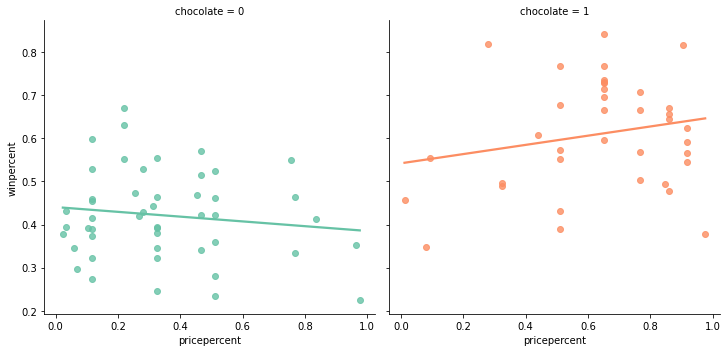

In [22]:
#Scatter plot with a regression line 
sns.lmplot(x = "pricepercent", y = "winpercent", data = df, 
           hue= "chocolate", col = "chocolate", col_wrap=3, 
           palette="Set2", ci = None)

In [23]:
no_choco_no_alm = df[(df["chocolate"] == 0) & (df["peanutyalmondy"] == 0)]["winpercent"]

print(f"No choco no alm candy average winperc: {np.mean(no_choco_no_alm)}")

with_choco_alm = df[(df["chocolate"] == 1) & (df["peanutyalmondy"] == 1)]["winpercent"]

print(f"Choco and alm candy average winperc: {np.mean(with_choco_alm)}")

with_choco_no_alm = df[(df["chocolate"] == 1) & (df["peanutyalmondy"] == 0)]["winpercent"]

print(f"With Choco and no alm candy average winperc: {np.mean(with_choco_no_alm)}")

No choco no alm candy average winperc: 0.4245652173913043
Choco and alm candy average winperc: 0.685
With Choco and no alm candy average winperc: 0.5728800000000001


In [24]:
# No much offering and this combo has a high win perc 
len(no_choco_no_alm), len(with_choco_alm), len(with_choco_no_alm)

(46, 12, 25)

In [25]:
#Indipendent two sample t_test: no_choco_no_alm vs with_choco_alm 
t_val, p_val = stats.ttest_ind(no_choco_no_alm, with_choco_alm)
print(f"t-value: {t_val}, p-value: {p_val}")

t-value: -7.8698931393377825, p-value: 1.2661150216323444e-10


In [26]:
 #Indipendent two sample t_test: no_choco_no_alm vs with_choco_no_alm 
t_val, p_val = stats.ttest_ind(no_choco_no_alm, with_choco_no_alm)
print(f"t-value: {t_val}, p-value: {p_val}")

t-value: -5.495327787291943, p-value: 6.123865714893236e-07


In [27]:
 #Indipendent two sample t_test: no_choco_no_alm vs with_choco_no_alm 
t_val, p_val = stats.ttest_ind(with_choco_alm, with_choco_no_alm)
print(f"t-value: {t_val}, p-value: {p_val}")

t-value: 2.70019542967287, p-value: 0.010603859044829765


We have always got a t-value: +-2.44 < +-1.96 and a p-value: 0.015 < 0.05, hence we always reject the null hypothesis that the difference between the two population mean is zero. However, the p-value in the last test is bigger, we may therefore infer that with a larger sample size the mean population difference would tend to zero, so no much difference in winning percent between with_choco_alm and with_choco_no_alm. 

If this is true, we could get kind of the same winning percent at lower cost, because we will have a candy with less ingredients. 

## OLS

In [30]:
df.columns

Index(['competitorname', 'chocolate', 'fruity', 'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
       'pricepercent', 'winpercent', 'sugarbyprice', 'winbyprice'],
      dtype='object')

In [76]:
#Store all the predictors in X
X = df.drop(["winpercent", "competitorname"], axis = 1)

#Store the target as y 
y = df["winpercent"].copy()

In [77]:
#Fit the OLS using all the possible predictors in the dataset 
model = sm.OLS.from_formula("y ~ X", data = df).fit()

#Chech the model's summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     6.932
Date:                Sat, 05 Mar 2022   Prob (F-statistic):           2.02e-08
Time:                        16:50:17   Log-Likelihood:                 77.580
No. Observations:                  85   AIC:                            -127.2
Df Residuals:                      71   BIC:                            -92.96
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3568      0.047      7.625      0.000       0.263       0.450
X[0]           0.1950      0.039      4.942      0.000       0.116       0.274
X[1]           0.0868      0.038      2.303      0.024       0.012       0.162
X[2]           0.0154      0.037      0.422      0.675      -0.057       0.088
X[3]           0.0992      0.036      2.760      0.007       0.028       0.171
X[4]           0.0005      0.057      0.009      0.993      -0.113       0.114
X[5]           0.0889      0.052      1.699      0.094      -0.015       0.193
X[6]          -0.0428      0.036     -1.189      0.238      -0.115       0.029
X[7]           0.0143      0.051      0.283      0.778      -0.087       0.115
X[8]          -0.0084      0.031     -0.276      0.783      -0.069       0.053
X[9]           0.1402      0.055      2.527      0.014       0.030       0.251
X[10]         -0.1053      0.065     -1.630      0.107      -0.234       0.023
X[11]         -0.0110      0.007     -1.688      0.096      -0.024       0.002
X[12]          0.0031      0.004      0.804      0.424      -0.005       0.011
==============================================================================
Omnibus:                        0.660   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.719   Jarque-Bera (JB):                0.767
Skew:                          -0.099   Prob(JB):                        0.681
Kurtosis:                       2.578   Cond. No.                         44.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
X = X.drop(["nougat", "caramel", "pluribus", "bar", "winbyprice", "hard", "sugarpercent", "pricepercent", "sugarbyprice"], axis=1)

In [80]:
X

,chocolate,fruity,peanutyalmondy,crispedricewafer
0,1,0,0,1
1,1,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,1,0,0
...,...,...,...,...
80,0,1,0,0
81,0,1,0,0
82,0,1,0,0
83,0,0,0,0


In [79]:
#Fit the OLS using all the possible predictors in the dataset 
model = sm.OLS.from_formula("y ~ X", data = df).fit()

#Chech the model's summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     19.36
Date:                Sat, 05 Mar 2022   Prob (F-statistic):           3.60e-11
Time:                        16:50:18   Log-Likelihood:                 71.521
No. Observations:                  85   AIC:                            -133.0
Df Residuals:                      80   BIC:                            -120.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3541      0.032     11.107      0.000       0.291       0.418
X[0]           0.2025      0.036      5.552      0.000       0.130       0.275
X[1]           0.0818      0.036      2.291      0.025       0.011       0.153
X[2]           0.1028      0.035      2.925      0.004       0.033       0.173
X[3]           0.0905      0.046      1.972      0.052      -0.001       0.182
==============================================================================
Omnibus:                        1.521   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.468   Jarque-Bera (JB):                1.311
Skew:                          -0.138   Prob(JB):                        0.519
Kurtosis:                       2.458   Cond. No.                         5.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
def my_ols(choco: int, fruit: int, alm: int, crisp: int): 
    win_perc =  0.3541 + (0.2025*choco) + (0.0818*fruit) + (0.1028*alm) + (0.0905*crisp)
    return f"The predicted salary has a value of: {win_perc * 100} %"

In [96]:
my_ols(choco=1, fruit=0, alm=1, crisp=1) 

'The predicted salary has a value of: 74.99 %'

In [97]:
my_ols(choco=1, fruit=0, alm=1, crisp=0)

'The predicted salary has a value of: 65.94 %'

In [104]:
my_ols(choco=1, fruit=1, alm=1, crisp=1)

'The predicted salary has a value of: 83.17 %'